# Practical work on Filter banks

#### Delhio CALVES, Rémi DUCOTTET
*From R. Badeau

**python version : 3.6**

In [26]:
import os, sys, wave, struct
import scipy.signal as sgn
import scipy.linalg as lng
import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import time

## Functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-60, 10)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)



## 1. Two-channel filter banks

### 1.2. Synthesis of a half-band filter

1. One coefficient over two is not non-null, so the $\textit{half-band condition}$ does not hold (see plot below).

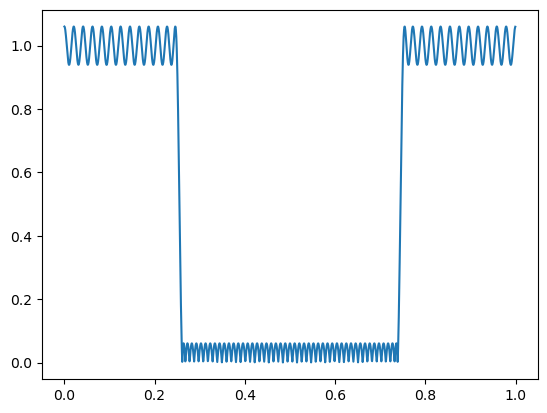

In [4]:
N = 50
M = 2048
g = sgn.remez(2*N-1, [0, 1./4., 1./4.+0.01, 0.5], [1, 0])
#print(g)
H = np.abs(np.fft.fft(g,M))
plt.plot(np.linspace(0,1,M,endpoint = False),H)

2. The ondulations of the signal are not of constant magnitude. Hence, the Chebyshev's alternance property does not hold (see plot below).

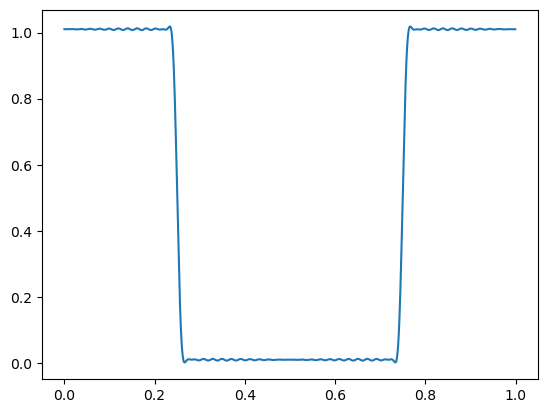

In [5]:
zeros = np.zeros(2*N-1)
a = g[N-1]
g[1::2] = zeros[1::2]
g[N-1] = a

G = np.abs(np.fft.fft(g,M))
plt.plot(np.linspace(0,1,M,endpoint = False),G)

3. We synthesize g by implementing a nearly-all-pass filter and intertwining zeros in between the terms except the central one which we set at 1.
Then, we compute the fast-Fourier Transform of the obtained sequence.
Below, you can observe the plots of frequencey response of the nearly-all-pass filter and the plot of the frequency response of the g filter.

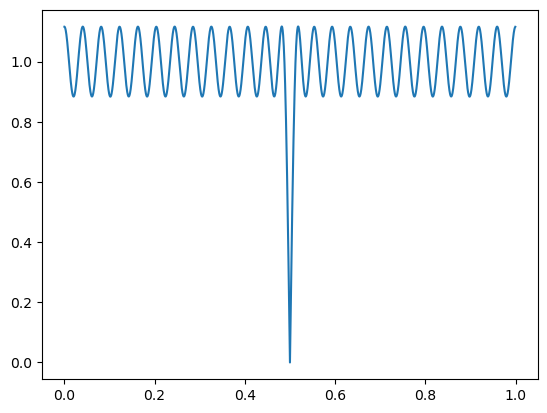

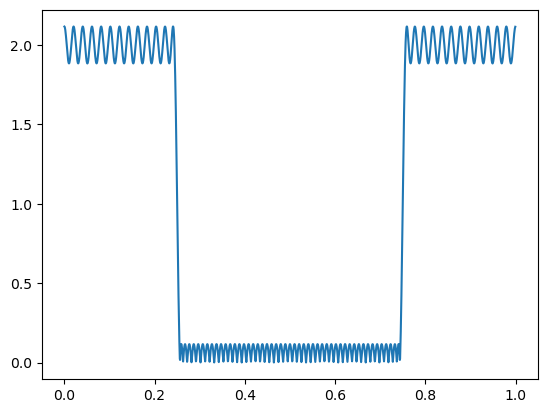

In [11]:
v = sgn.remez(N, [0, 1./2.-0.01, 1./2., 1./2.],[1,0])
V = np.abs(np.fft.fft(v,M))
plt.plot(np.linspace(0,1,M, endpoint=False),V)
plt.show()
g = np.zeros(2*N-1)
g[::2] = v
g[N-1] = 1
G = np.abs(np.fft.fft(g,M))
plt.plot(np.linspace(0,1,M, endpoint=False),G)
plt.show()

### 1.3 Raising and factorization of the half-band filter

4. By computing $G_R(\nu)=e^{2i\pi\nu(N-1)}G(\nu)$, we observe that it is not non-negative.

Thanks to the lecture note, we can deduce that we cannot factorize $G_R(\nu)$. Let us highlight this characteristic by plotting it.

G_R is not non-negative :  True


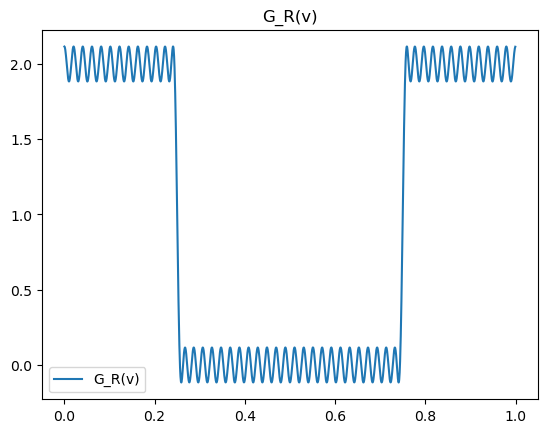

In [15]:
G_R = np.fft.fft(g, M)*np.exp(np.linspace(0, 2j*np.pi*(N-1), M, endpoint=False))

#Test if G_R is non-negative :
print("G_R is not non-negative : ", np.min(np.real(G_R))<0)

#Plot G_R(v)
plt.plot(np.linspace(0,1,M, endpoint=False), np.real(G_R), label='G_R(v)')
plt.legend()
plt.title("G_R(v)")
plt.show()

5. We define $g^+(n) = g(n) + \epsilon\delta(n-(N_1))$ using $\epsilon = 0.12$ and verify that we obtain the expected properties.
Indeed, now we have $\forall \nu \in [0,1[, G^+_R(\nu)>0$ and $G^+_R(\nu)+G^+_R(\nu+\frac{1}{2})$ is still constant.

G_R is non-negative :  True


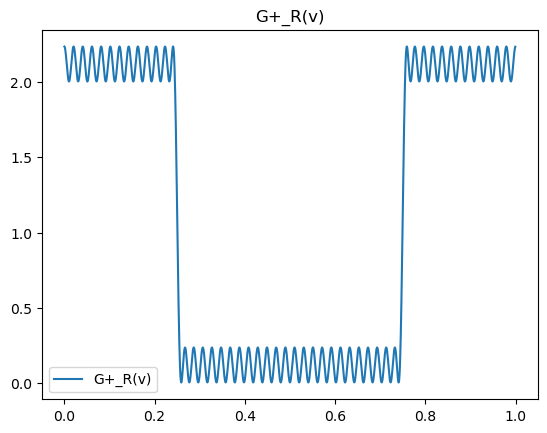

In [20]:
gp = np.copy(g)
gp[N-1] = gp[N-1] + 0.12
Gp_R = np.fft.fft(gp, M)*np.exp(np.linspace(0, 2j*np.pi*(N-1), M, endpoint=False))

#Test if Gp_R is non-negative :
print("G_R is non-negative : ", np.min(np.real(Gp_R))>=0)

#Plot G_R(v)
plt.plot(np.linspace(0,1,M, endpoint=False), np.real(Gp_R), label='G+_R(v)')
plt.legend()
plt.title("G+_R(v)")
plt.show()

6. Let us implement the iterations indicated by the subject.

In [38]:
h_0 = [0 for i in range(N)]
h_0[0] = g[N-1]

mat = np.zeros(N)
mat[N-1] = h_0[0]
H = lng.hankel(mat, h_0) # solve triangular system

for i in range(1, N):
    h_0 = lng.solve(H, g[0:N])
    norm = np.sqrt(np.sum(h_0**2)) # compute the 2-norm
    h_0 = (h_0 / norm )* np.sqrt(g[N-1]) # renormalize H_0
    mat = np.zeros(N)
    mat[N-1] = h_0[0]
    H = lng.hankel(mat, h_0)
print(h_0)

[-0.76595521 -0.58609284 -0.09530588  0.16771314  0.05557701 -0.09200274
 -0.03884495  0.06177069  0.02967693 -0.04587148 -0.02387084  0.03609846
  0.01988681 -0.02957681 -0.01696723  0.02489729  0.01473078 -0.02136497
 -0.01299624  0.01872482  0.01150461 -0.0163881  -0.01035013  0.01466148
  0.00936052 -0.01319556 -0.00848898  0.01190222  0.00772335 -0.01077286
 -0.00705446  0.00976565  0.006466   -0.00889459 -0.00593324  0.00808682
  0.00544206 -0.00730936 -0.00498951  0.0065504   0.00453902 -0.00566519
 -0.00407657  0.00447596  0.00352163 -0.00207264 -0.00259906 -0.0103265
  0.03057757 -0.06666401]


C:\Users\Delhio\AppData\Local\Temp\ipykernel_21572\2526427914.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=9.75621e-17): result may not be accurate.
  h_0 = lng.solve(H, g[0:N])
C:\Users\Delhio\AppData\Local\Temp\ipykernel_21572\2526427914.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=5.34546e-26): result may not be accurate.
  h_0 = lng.solve(H, g[0:N])
C:\Users\Delhio\AppData\Local\Temp\ipykernel_21572\2526427914.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=1.1576e-36): result may not be accurate.
  h_0 = lng.solve(H, g[0:N])
C:\Users\Delhio\AppData\Local\Temp\ipykernel_21572\2526427914.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=1.44918e-60): result may not be accurate.
  h_0 = lng.solve(H, g[0:N])


## 2. Transmultiplexer

1. Even if we have computed the signals $F_0, F_1, H_0, H_1$, we decide to take the signals given by the subject by security.

In [8]:
data_path = os.getcwd()
filename = 'homme3.wav'
filename2 = 'femme3.wav'
sound = os.path.join(data_path, filename) 
sound2 = os.path.join(data_path, filename2) 
wavefile = load_sound(sound)
wavefile2 = load_sound(sound2)

print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 
play2 = False
if play2 :
    play_sound(sound2) 
    
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
data2 = wavefile2.readframes(num_samples)
data2 = struct.unpack('{n}h'.format(n=num_samples), data2)
S0 = np.array(data)
S1 = np.array(data2)

S0_tilde = np.zeros(2*len(S0)) # insertion of
S0_tilde[0:len(S0_tilde):2] = S0     # zeros
S0_tilde_shifted = np.concatenate((np.zeros(1), S0_tilde))[0:len(S0_tilde)] #forth-shifting

S1_tilde = np.zeros(2*len(S1)) # insertion of
S1_tilde[0:len(S0_tilde):2] = S1     # zeros

sum = S0_tilde_shifted + S1_tilde

X = np.concatenate((np.zeros(1), sum))[0:len(sum)+1]
write('mixed.wav', 2*Fs, np.array(X, dtype=np.int16))
data_path = os.getcwd()
filename3 = 'mixed.wav'
sound3 = os.path.join(data_path, filename3)
wavefile3 = load_sound(sound3)
play_sound(sound3)

S0_hat = X
S1_hat = np.concatenate((np.zeros(1), X))[0:len(X)] # forth-shifting

S0_hat_decim = S0_hat[0:len(S0_hat):2]   # decimation
S1_hat_decim = S1_hat[0:len(S1_hat):2]

S0_final = S0_hat_decim[1:len(S0_hat_decim)] # remove first
S1_final = S1_hat_decim[1:len(S1_hat_decim)] # null sample

print("There is perfect reconstruction : ",(S0 == S0_final).all() & (S1 == S1_final).all())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')
There is perfect reconstruction :  True


 2. a) If $\alpha = 0.9$, we choose $D(z) = \frac{z^{-1}}{1-\alpha z^{-1}}$ because it is causal and stable. Moreover, $C(z)D(z) = z^{-1}$ and we get perfect reconstruction, this implementation was already tested in the previous question.
 $\newline$
 b) Let us test an approximation of the stable implementation of $D(z)$. In order to do so, let us truncate the anti-causal, infinite impulse response of the stable implementation of $D(z)$, and translate it over time so that it becomes causal. We note that the approximation gives us a good result.

In [9]:
d = np.zeros(1000)
a = 1.2
for i in range (0, len(d)):
    d[i] = -a**(i - len(d))

c = np.zeros(len(d))
c[0] = 1
c[1] = -a

y = np.convolve(c, d)
Y = np.fft.fft(y)

data_path = os.getcwd()
filename = 'homme3.wav'
filename2 = 'femme3.wav'
sound = os.path.join(data_path, filename) 
sound2 = os.path.join(data_path, filename2) 
wavefile = load_sound(sound)
wavefile2 = load_sound(sound2)

print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 
play2 = False
if play2 :
    play_sound(sound2) 
    
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
data2 = wavefile2.readframes(num_samples)
data2 = struct.unpack('{n}h'.format(n=num_samples), data2)
S0 = np.array(data)
S1 = np.array(data2)

S0_tilde = np.zeros(2*len(S0)) # insertion of
S0_tilde[0:len(S0_tilde):2] = S0     # zeros
S0_tilde_shifted = np.concatenate((np.zeros(1), S0_tilde))[0:len(S0_tilde)] #forth-shifting

S1_tilde = np.zeros(2*len(S1)) # insertion of
S1_tilde[0:len(S0_tilde):2] = S1     # zeros

sum = S0_tilde_shifted + S1_tilde

X = np.convolve(c, sum)[0:len(sum)+1]
Y = np.convolve(d, X)[0:len(sum)+1]

S0_hat = Y
S1_hat = np.concatenate((np.zeros(1), Y))[0:len(Y)] # forth-shifting

S0_hat_decim = S0_hat[0:len(S0_hat):2]   # decimation
S1_hat_decim = S1_hat[0:len(S1_hat):2]

S0_final = S0_hat_decim[1:len(S0_hat_decim)] # remove first
S1_final = S1_hat_decim[1:len(S1_hat_decim)] # null sample

write('split.wav', Fs, np.array(S0_final, dtype=np.int16))
data_path = os.getcwd()
filename4 = 'split.wav'
sound4 = os.path.join(data_path, filename4)
wavefile4 = load_sound(sound4)
play_sound(sound4)

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


3. We use a unit impulse signal as input of our implementation. Let us use the output signal of the right part of the previous multiplexer as input signal and of the new one and the left part of the same previous multiplexer as output the one. This method should achieve finding the impulse response of $C(z)$ with a delay and a gain factor.

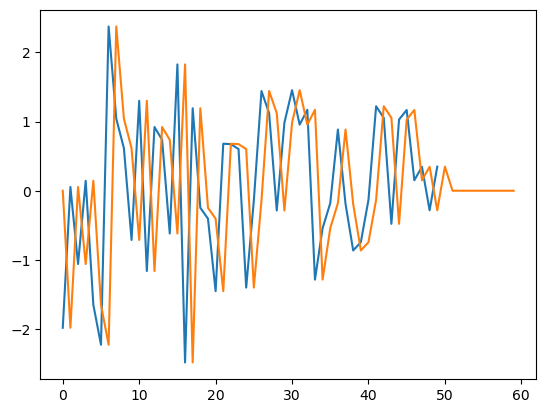

In [10]:
x = np.zeros(10)
x[0] = 1
S0 = np.concatenate((np.zeros(1), x))[0:len(x)] # forth-shifting
S1 = np.copy(x)
S0 = S0[0:len(S0):2]   # decimation
S1 = S1[0:len(S1):2]

S0_ = np.zeros(2*len(S0)) # insertion of
S0_[0::2] = S0     # zeros
S0 = S0_

S0 = np.concatenate((np.zeros(1), S0))[0:len(S0)] #forth-shifting

S1_ = np.zeros(2*len(S1)) # insertion of
S1_[0::2] = S1     # zeros
S1 = S1_

sum = S0 + S1

c = np.random.randn(50)

X = np.convolve(c, sum)

S1 = np.concatenate((np.zeros(1), X))[0:len(X)] # forth-shifting
S0 = np.copy(X)

S0 = S0[0:len(S0):2]   # decimation
S1 = S1[0:len(S1):2]

S0_ = np.zeros(2*len(S0)) # insertion of
S0_[0::2] = S0     # zeros
S0 = S0_

S0 = np.concatenate((np.zeros(1), S0))[0:len(S0)] #forth-shifting

S1_ = np.zeros(2*len(S1)) # insertion of
S1_[0::2] = S1     # zeros
S1 = S1_

sum2 = S0 + S1

plt.plot(c)
plt.plot(sum2)
plt.show()